In [51]:
import anndata as ad
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import mudata
import os
from scipy.spatial.distance import cdist
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
mudata.set_options(pull_on_update=False)
import moscot
from moscot.problems.cross_modality import TranslationProblem
import bbknn
from scipy.stats import mannwhitneyu
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2


def compute_kbet(embedding, batch_labels, k=50, alpha=0.05):
    n_cells = embedding.shape[0]
    batch_labels = np.array(batch_labels)
    unique_batches = np.unique(batch_labels)
    batch_counts = np.array([(batch_labels == b).sum() for b in unique_batches])
    batch_probs = batch_counts / n_cells

    # Nearest neighbors
    nn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(embedding)
    distances, neighbors = nn.kneighbors(embedding)

    p_values = np.zeros(n_cells)
    rejections = np.zeros(n_cells, dtype=bool)

    for i in range(n_cells):
        neighbor_labels = batch_labels[neighbors[i]]
        observed_counts = np.array([(neighbor_labels == b).sum() for b in unique_batches])
        expected_counts = batch_probs * k

        # Chi-squared test
        with np.errstate(divide='ignore', invalid='ignore'):
            chi2_stat = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
            p_val = 1 - chi2.cdf(chi2_stat, df=len(unique_batches) - 1)
        
        p_values[i] = p_val
        rejections[i] = p_val < alpha

    rejection_rate = rejections.mean()
    return rejection_rate, p_values

def kbet_celltypes(adata, embedding_key='X_lsi', batch_key='assay', celltype_key='celltype', k=5, alpha=0.05):
    results = {}
    embedding = adata.obsm[embedding_key]
    batch_labels = adata.obs[batch_key].values
    celltypes = adata.obs[celltype_key].unique()

    for ct in celltypes:
        idx = adata.obs[celltype_key] == ct
        if idx.sum() < k:
            continue

        emb_sub = embedding[idx]
        batch_sub = batch_labels[idx]
        rejection_rate, _ = compute_kbet(emb_sub, batch_sub, k=k, alpha=alpha)
        results[ct] = rejection_rate

    return results

In [52]:
germ_layer_markers = {}
with open('external_data/embryonic_layer_markers2.txt', 'r') as f:
    for line in f:
        _l = line.strip().split(',')
        _ll = _l[0]
        _m = _l[1::]
        germ_layer_markers[_ll] = _m

# scNMT part

In [83]:
adata = mudata.read_h5mu("mudata/gastro/scNMT.h5mu")
adata.obs['timepoint'] = [i.split('_')[0] for i in adata.obs.index]

mudat = mudata.MuData(
    {
        'ACC': adata['ACC'][: ,np.array(adata['ACC'].var['class'].isin(['promoters', 'enhancers']))].copy(),
        'METH': adata['METH'][: ,np.array(adata['METH'].var['class'].isin(['promoters', 'enhancers']))].copy(),
        'RNA':  adata['RNA'].copy()
    }
)
mudat['ACC'].var['gene'] = mudat['ACC'].var.index
mudat['METH'].var['gene'] = mudat['METH'].var.index
mudat['ACC'].var['peakname'] = mudat['ACC'].var['chrom'].astype(str) + '_' + mudat['ACC'].var['start'].astype(str) + '_' + mudat['ACC'].var['end'].astype(str)
mudat['METH'].var['peakname'] = mudat['METH'].var['chrom'].astype(str) + '_' + mudat['METH'].var['start'].astype(str) + '_' + mudat['METH'].var['end'].astype(str)
acc2gene = {}
with open('external_data/acc2name.txt') as f:
    for line in f:
        acc2gene[line.strip().split('\t')[0]] = line.strip().split('\t')[1]
mudat['RNA'].var['gene_name'] = mudat['RNA'].var.index.map(acc2gene)
mudat['RNA'].obs['timepoint'] = [i.split('_')[0] for i in adata.obs.index]
mudat['METH'].obs['timepoint'] = [i.split('_')[0] for i in adata.obs.index]
mudat['ACC'].obs['timepoint'] = [i.split('_')[0] for i in adata.obs.index]

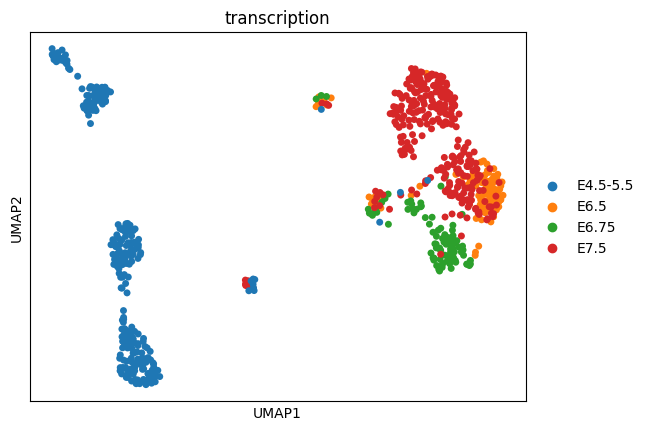

In [84]:
_rna = mudat['RNA'].copy()
sc.pp.normalize_total(_rna)
sc.pp.log1p(_rna)
sc.pp.highly_variable_genes(_rna, n_top_genes=1000)
sc.pp.pca(_rna)
sc.pp.neighbors(_rna, n_neighbors=15, n_pcs=25)
sc.tl.leiden(_rna, resolution=0.25)
sc.tl.umap(_rna)
_rna.obs['transcription'] = _rna.obs['leiden']
sc.pl.umap(_rna, color='timepoint', size=100, title = 'transcription', save='gastr_rna_timepoints.png')

In [85]:
mudat['METH']
X_bin = (mudat['METH'].X > 0).astype(int)
X_bin = sp.sparse.csr_matrix(X_bin)
row_sums = np.array(X_bin.sum(axis=1)).flatten()[:, np.newaxis] 
X_log_scnmt = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
X_log_scnmt.data = np.log1p(X_log_scnmt.data)
svd = TruncatedSVD(n_components=100, random_state=0)
mudat['METH'].obsm["X_lsi"] = svd.fit_transform(X_log_scnmt)
sc.pp.neighbors(mudat['METH'], use_rep="X_lsi", n_neighbors=20)
sc.tl.umap(mudat['METH'])
sc.tl.leiden(mudat['METH'], resolution=0.5)

/tmp/ipykernel_90532/744089393.py:5: RuntimeWarning: divide by zero encountered in divide
  X_log_scnmt = X_bin.multiply(1e4 / row_sums) # columns sparce matrix


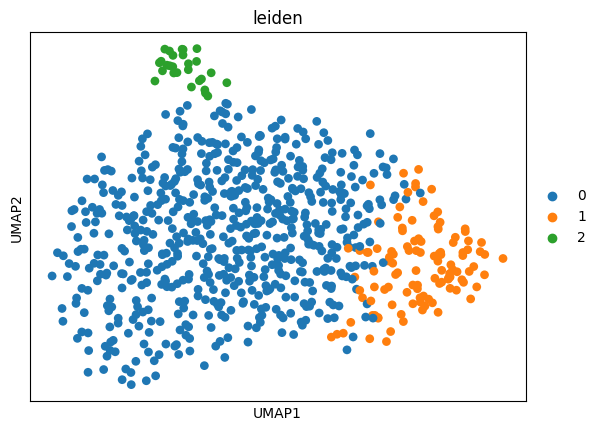

In [86]:
sc.pl.umap(mudat['METH'], color='leiden')

/tmp/ipykernel_90532/3999984037.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_methsig = mudat['METH'].to_df().groupby(mudat['METH'].obs['leiden']).mean()


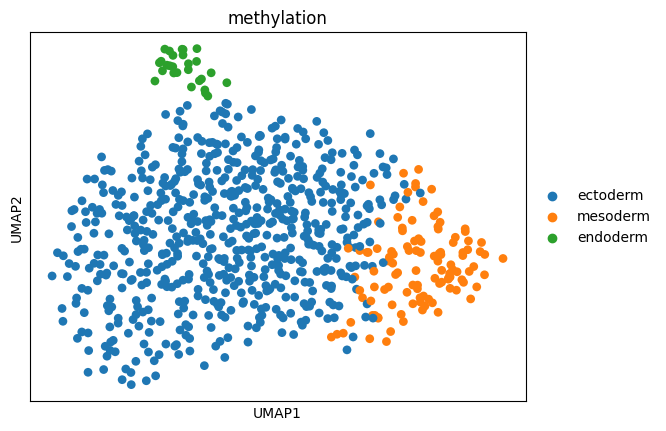

In [87]:
cluster_methsig = mudat['METH'].to_df().groupby(mudat['METH'].obs['leiden']).mean()
dfs = []
for celltype, markers in germ_layer_markers.items():
    fms = [i for i in markers if i in cluster_methsig.columns]
    dfs.append(cluster_methsig[fms].mean(axis=1).fillna(0.0))

layerscores = pd.concat(dfs, axis=1)
layerscores
layerscores.columns = germ_layer_markers.keys()
layerscores = layerscores.idxmin(axis=1).to_dict()
mudat['METH'].obs['celltype'] = mudat['METH'].obs['leiden'].map(layerscores)
#mudat['METH'].obs['celltype'] = mudat['METH'].obs.index.map(layerscores)
sc.pl.umap(mudat['METH'], color='celltype', title='methylation', save='gastr_meth_layers.png')

# scbs

In [88]:
_m = sp.io.mmread('external_data/scbs_gastro/scbs.meth.mtx').todense()
_c = sp.io.mmread('external_data/scbs_gastro/scbs.cov.mtx').todense()

X = np.zeros_like(_m, dtype=float)
X = np.where((_c != 0) & (_m != 0), _m / _c, 0)
X = sp.sparse.csr_matrix(X)
X
_obs = pd.read_csv('external_data/scbs_gastro/scbs.cell.tsv', sep='\t', header=None)
_obs.columns = ['cell']
_obs['cell'] = [i.split('/')[-1].replace('.WCGN-Both.allc.tsv.gz' ,'') for i in _obs['cell']]
_obs['timepoint'] = 'E6.5'
_var = pd.read_csv('external_data/scbs_gastro/scbs.meta.tsv', sep='\t', header=0)
_var['peakname'] = _var['chrom'].astype(str) + '_' + _var['start'].astype(str) + '_' + _var['end'].astype(str)

/tmp/ipykernel_90532/986661510.py:5: RuntimeWarning: invalid value encountered in divide
  X = np.where((_c != 0) & (_m != 0), _m / _c, 0)


In [89]:
scbs = ad.AnnData(
    X=X,
    obs=_obs,
    var=_var
)
_annotation = pd.read_table('external_data/uropa/scNMT_regions_annotation_finalhits.txt')
_annotation['peakname'] = _annotation["peak_chr"] + "_" + _annotation["peak_start"].astype(str) + "_" + _annotation["peak_end"].astype(str)
_annotation = _annotation[['relative_location', 'gene_name', 'peakname']].drop_duplicates(subset='peakname', keep='first')
scbs.var = pd.merge(scbs.var, _annotation[['relative_location', 'gene_name', 'peakname']], left_on='peakname', right_on='peakname', how='left')

scbs = scbs[: ,np.array(scbs.var['class'].isin(['promoters', 'enhancers']))].copy()

/localenv/deboutte/anaconda/miniconda/envs/moscot_book/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/localenv/deboutte/anaconda/miniconda/envs/moscot_book/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/localenv/deboutte/anaconda/miniconda/envs/moscot_book/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [90]:
scbs.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8069 stored elements and shape (187, 105196)>

In [91]:
X_bin = (scbs.X > 0).astype(int)
row_sums = np.array(X_bin.sum(axis=1)).flatten()[:, np.newaxis] 
X_log_scbs = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
X_log_scbs.data = np.log1p(X_log_scbs.data)
svd = TruncatedSVD(n_components=100, random_state=0)
scbs.obsm["X_lsi"] = svd.fit_transform(X_log_scbs)
sc.pp.neighbors(scbs, use_rep="X_lsi", n_neighbors=20)
sc.tl.umap(scbs)
sc.tl.leiden(scbs, resolution=0.6)

/tmp/ipykernel_90532/1079002832.py:3: RuntimeWarning: divide by zero encountered in divide
  X_log_scbs = X_bin.multiply(1e4 / row_sums) # columns sparce matrix


/tmp/ipykernel_90532/947908851.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_methsig = scbs.to_df().groupby(scbs.obs['leiden']).mean()


['Sox17', 'Foxa2', 'Gata4', 'Cxcr4', 'Hhex', 'Eomes', 'Gata6']
['Pax6', 'Sox1', 'Sox2', 'Zic1', 'Zic2', 'Otx2', 'Hes3']
['T', 'Mesp1', 'Tbx6', 'Hand1', 'Hand2']


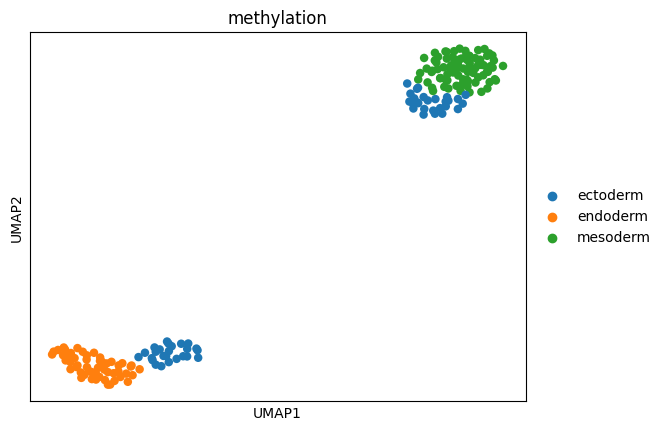

In [92]:
cluster_methsig = scbs.to_df().groupby(scbs.obs['leiden']).mean()
cluster_methsig.columns = scbs.var['name']
dfs = []
for celltype, markers in germ_layer_markers.items():
    fms = [i for i in markers if i in cluster_methsig.columns]
    print(fms)
    dfs.append(cluster_methsig[fms].mean(axis=1).fillna(0.0))

layerscores = pd.concat(dfs, axis=1)

layerscores.columns = germ_layer_markers.keys()
layerscores = layerscores.idxmin(axis=1).to_dict()
layerscores

scbs.obs['celltype'] = scbs.obs['leiden'].map(layerscores)
sc.pl.umap(scbs, color='celltype', title='methylation', size=150, save='gastrscbs_meth_layers.png')

# OT

In [93]:
proj_distances=[]
def intr_dists(adata,rep_key,group_key) -> dict:
    X = adata.obsm[rep_key]
    labels = adata.obs[group_key]

    results = {}
    for group in labels.unique():
        idx = labels == group
        X_group = X[idx.values]
        dists = sp.spatial.distance.pdist(X_group)
        results[group] = dists

    unique_groups = labels.unique()

    for i, group1 in enumerate(unique_groups):
        for j in range(i + 1, len(unique_groups)):
            group2 = unique_groups[j]
            idx1 = labels == group1
            idx2 = labels == group2
            X1 = X[idx1.values]
            X2 = X[idx2.values]

            dists = cdist(X1, X2)  # shape: (n_group1, n_group2)
            results[(group1, group2)] = dists
    return results

In [94]:
scbs = scbs[ :, ~scbs.var['peakname'].duplicated() ]
mudat.mod['METH'] = mudat['METH'][ :, ~mudat['METH'].var['peakname'].duplicated() ]

common_peaks = np.intersect1d(scbs.var['peakname'], mudat['METH'].var['peakname'])
scbs = scbs[ :, scbs.var['peakname'].isin(common_peaks)]
mudat.mod['METH'] = mudat['METH'][ :, mudat['METH'].var['peakname'].isin(common_peaks)]


tp = TranslationProblem(scbs, mudat['METH'])
tp = tp.prepare(src_attr="X_lsi", tgt_attr="X_lsi")
#tp = tp.solve(epsilon=_eps, alpha=_alpha, rank=_rank)
tp = tp.solve(epsilon=1e-4, min_iterations=10000)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(187, 758)].                                            
WARNING  Solver did not converge                                                                                   


In [95]:
translated = tp.translate(source="src", target="tgt", forward=True)

adata = sc.concat(
    [scbs, mudat['METH']],
    join="outer",
    label="assay",
    keys=["translated_scbs", "scNMT"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, mudat['METH'].obsm["X_lsi"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1", n_neighbors=50)
sc.tl.umap(adata)

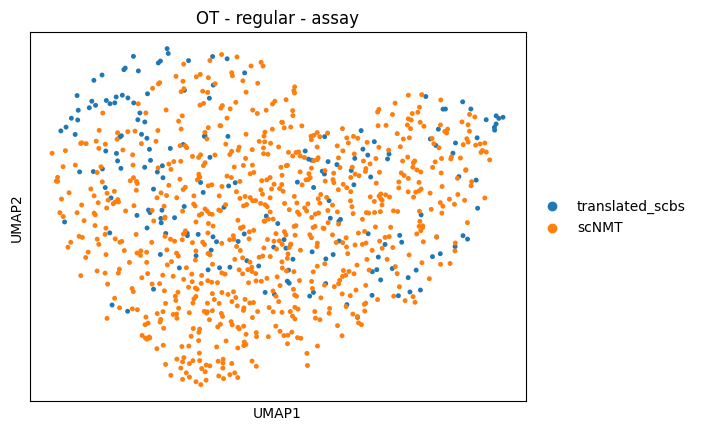

In [96]:
sc.pl.umap(adata, color='assay', size=50, title='OT - regular - assay', save='integration_OT_assay.png')

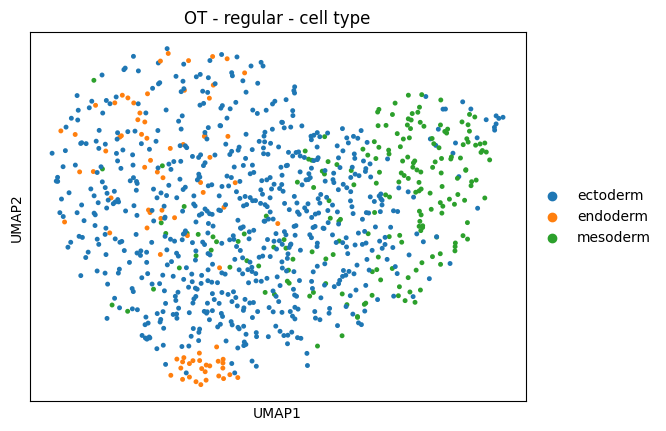

In [97]:
sc.pl.umap(adata, color='celltype', size=50, title='OT - regular - cell type', save='integration_OT_celltype.png')

In [100]:
opt_reg_kbet = kbet_celltypes(adata, embedding_key='X_translated_1')

In [102]:
resdic = intr_dists(adata, 'X_translated_1', 'celltype')
for layer in resdic:
    for dist in resdic[layer]:
        if not isinstance(dist, np.float64):
            for _d in dist:
                proj_distances.append(
                    ['OT - basic', layer, _d]
                )
        else:
            proj_distances.append(
                    ['OT - basic', layer, dist]
                )


In [103]:
X_bin = (mudat['METH'].X > 0).astype(int)
X_bin = sp.sparse.csr_matrix(X_bin)
row_sums = np.array(X_bin.sum(axis=1)).flatten()[:, np.newaxis] 
X_log_scnmt = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
X_log_scnmt.data = np.log1p(X_log_scnmt.data)

X_bin = (scbs.X > 0).astype(int)
row_sums = np.array(X_bin.sum(axis=1)).flatten()[:, np.newaxis] 
X_log_scbs = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
X_log_scbs.data = np.log1p(X_log_scbs.data)

X_all = np.vstack([X_log_scbs.toarray(), X_log_scnmt.toarray()])
svd = TruncatedSVD(n_components=20, random_state=0)
pca = PCA(n_components=20, random_state=0)

X_lsi = svd.fit_transform(X_all)
X_pca = pca.fit_transform(X_all)

scbs.obsm["X_joint_lsi"] = X_lsi[:scbs.X.shape[0]]
mudat['METH'].obsm["X_joint_lsi"] = X_lsi[scbs.X.shape[0]:]

scbs.obsm["X_joint_pca"] = X_pca[:scbs.X.shape[0]]
mudat['METH'].obsm["X_joint_pca"] = X_pca[scbs.X.shape[0]:]

/tmp/ipykernel_90532/783146054.py:4: RuntimeWarning: divide by zero encountered in divide
  X_log_scnmt = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
/tmp/ipykernel_90532/783146054.py:9: RuntimeWarning: divide by zero encountered in divide
  X_log_scbs = X_bin.multiply(1e4 / row_sums) # columns sparce matrix
/tmp/ipykernel_90532/783146054.py:19: ImplicitModificationWarning: Setting element `.obsm['X_joint_lsi']` of view, initializing view as actual.
  scbs.obsm["X_joint_lsi"] = X_lsi[:scbs.X.shape[0]]
/tmp/ipykernel_90532/783146054.py:20: ImplicitModificationWarning: Setting element `.obsm['X_joint_lsi']` of view, initializing view as actual.
  mudat['METH'].obsm["X_joint_lsi"] = X_lsi[scbs.X.shape[0]:]


In [104]:
tp = TranslationProblem(scbs, mudat['METH'])
tp = tp.prepare(src_attr="X_lsi", tgt_attr="X_lsi", joint_attr="X_joint_lsi")
tp = tp.solve(epsilon=1e-4, alpha=0.7)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(187, 758)].                                            
WARNING  Solver did not converge                                                                                   


In [105]:
translated = tp.translate(source="src", target="tgt", forward=True)

adata = sc.concat(
    [scbs, mudat['METH']],
    join="outer",
    label="assay",
    keys=["translated_scbs", "scNMT"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, mudat['METH'].obsm["X_lsi"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1", n_neighbors=50)
sc.tl.umap(adata)

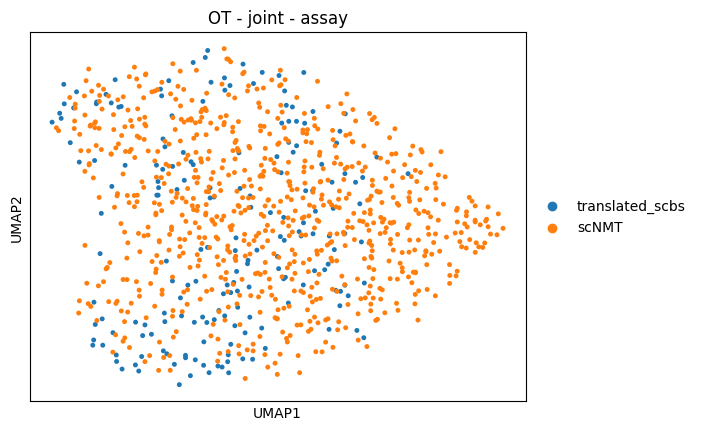

In [106]:
sc.pl.umap(adata, color='assay', size=50, title='OT - joint - assay', save='integration_OT_ext_assay.png')

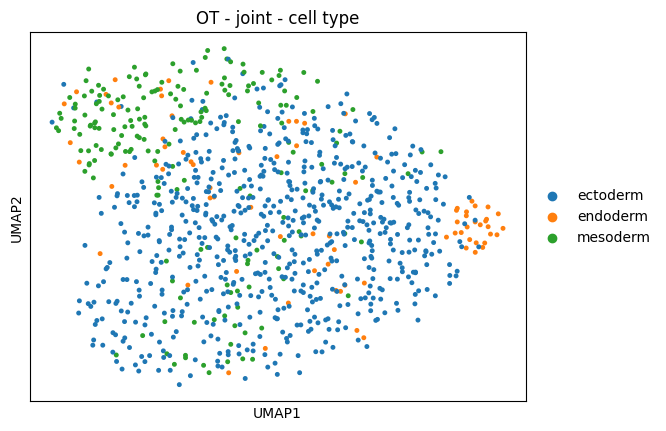

In [107]:
sc.pl.umap(adata, color='celltype', size=50, title='OT - joint - cell type', save='integration_OT_ext_celltype.png')

In [108]:
opt_adv_kbet = kbet_celltypes(adata, embedding_key='X_translated_1')

In [109]:
resdic = intr_dists(adata, 'X_translated_1', 'celltype')
for layer in resdic:
    for dist in resdic[layer]:
        if not isinstance(dist, np.float64):
            for _d in dist:
                proj_distances.append(
                    ['OT - ext', layer, _d]
                )
        else:
            proj_distances.append(
                    ['OT - ext', layer, dist]
                )


# BBKNN

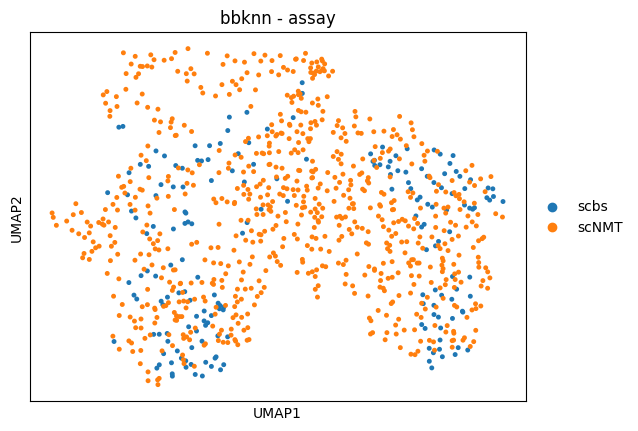

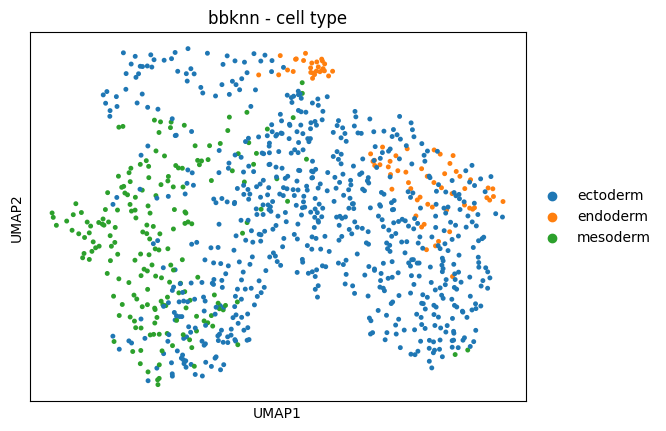

In [110]:
_bbk_scbs = scbs.copy()
_bbk_muda = mudat['METH'].copy()

_bbk_scbs.X = X_log_scbs.toarray()
_bbk_muda.X = X_log_scnmt.toarray()

bbkadata = ad.concat([_bbk_scbs, _bbk_muda], join="outer", label="batch", fill_value=0)
bbkadata.obs['assay'] = bbkadata.obs['batch'].map({'0': 'scbs', '1': 'scNMT'})

bbknn.bbknn(bbkadata, batch_key='assay', use_rep='X_lsi')
sc.tl.umap(bbkadata)
sc.pl.umap(bbkadata, color=["assay"], title='bbknn - assay', size=50, save='integration_BBKNN_assay.png')
sc.pl.umap(bbkadata, color=["celltype"],title='bbknn - cell type', size=50, save='integration_BBKNN_celltype.png')

In [111]:
resdic = intr_dists(bbkadata, 'X_lsi', 'celltype')
for layer in resdic:
    for dist in resdic[layer]:
        if not isinstance(dist, np.float64):
            for _d in dist:
                proj_distances.append(
                    ['BBKNN', layer, _d]
                )
        else:
            proj_distances.append(
                    ['BBKNN', layer, dist]
                )


In [112]:
resdf = pd.DataFrame(proj_distances)
resdf.columns = ['method', 'layer', 'distance']
resdf['layer_collapsed'] = resdf['layer'].map({'mesoderm': 'mesoderm', 'ectoderm':'ectoderm', 'endoderm':'endoderm'})
resdf['layer_collapsed'] = resdf['layer_collapsed'].fillna('between')
dfs = []
for i in resdf['method'].unique():
    _df = resdf[resdf['method'] == i].copy()
    dfs.append(_df)
    _df2 = resdf[resdf['method'] == i].copy()
    _df2['layer_collapsed'] = 'all'
    dfs.append(_df2)
findf = pd.concat(dfs, axis=0)
findf = findf[findf['layer_collapsed'] != 'between']

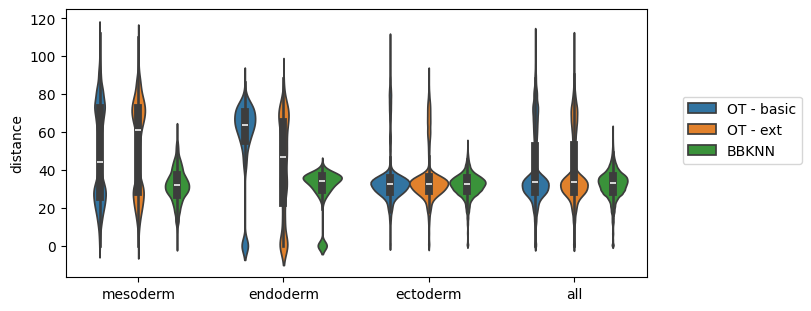

In [113]:
fig,ax = plt.subplots(figsize=(8,3), constrained_layout=True)
sns.violinplot(
    data=findf,
    x='layer_collapsed',
    y='distance',
    hue='method',
    ax=ax
)
ax.set_xlabel('')
ax.legend(bbox_to_anchor=[1.05, 0.7])
fig.savefig('figures/integration_performance_METH.png', dpi=300)

In [114]:
ress = []
for layer in ['mesoderm', 'ectoderm', 'endoderm']:    
    stat, pval = mannwhitneyu(
        findf[findf['layer_collapsed'] == layer]['distance'],
        findf[findf['layer_collapsed'] == 'all']['distance'],
        alternative='two-sided'
    )
    ress.append([stat, pval, layer])
ress

[[np.float64(73354656007.0), np.float64(0.0), 'mesoderm'],
 [np.float64(726578201142.0), np.float64(0.0), 'ectoderm'],
 [np.float64(14574939829.0), np.float64(0.0), 'endoderm']]

In [115]:
bbknn_kbet = kbet_celltypes(bbkadata)

In [117]:
opt_reg_kbet

{'mesoderm': np.float64(0.17098445595854922),
 'endoderm': np.float64(0.3875),
 'ectoderm': np.float64(0.06845238095238096)}

In [118]:
opt_adv_kbet

{'mesoderm': np.float64(0.24352331606217617),
 'endoderm': np.float64(0.3625),
 'ectoderm': np.float64(0.028273809523809524)}

In [116]:
bbknn_kbet

{'mesoderm': np.float64(0.13471502590673576),
 'endoderm': np.float64(0.3375),
 'ectoderm': np.float64(0.07142857142857142)}